# Grado en Robótica - Visión Artificial
## Práctica 7: Detector de objetos (HoG + SVM)
### Autor: Adrián Losada Álvarez

# Tarea 1: Detector de objetos basado en HoG + SVM

### Importamos las librerías necesarias

In [1]:
import cv2
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import shutil
import os
import random
import scipy
from sklearn.ensemble import RandomForestClassifier
import pickle
import imutils

/home/adrian/.virtualenvs/VAA/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/adrian/.virtualenvs/VAA/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/adrian/.virtualenvs/VAA/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/adrian/.virtualenvs/VAA/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


### a) Dentro de la base de datos CALTECH-101 elegí la carpeta 'hawksbill' que contiene imágenes de tortugas carey

In [2]:
my_object = 'hawksbill'

### b) Preparamos los datos en carpetas de positivos y negativos para la fase de adestramiento y test

#### Algoritmo para generar base de datos con imagenes aleatorias a partir de la base '101_ObjectCategories'
#### **NOTA: SI SE QUIERE CAMBIAR EL OBJETO A DETECTAR, DEBES DE DESCOMENTAR EL SIGUIENTE KERNEL, SE DEBE DE COPIAR LA CARPETA 'caltech101' AL PATH ESPECIFICADO EN LAS PRIMERAS LÍNEAS O AJUSTAR LOS PATHS SI SE QUIERE EJECUTAR (MODIFICAR SOLO DONDE SE INDIQUE)**

In [3]:
"""# Definimos el path a la base de datos con todas las imágenes y el directorio destino
random_images_origin = './data/caltech101/101_ObjectCategories/'  # <--- MODIFICAR RUTA SI SE QUIERE MODIFICAR EL OBJETO A DETECTAR!!

# Definimos nuestro objeto a reconocer (nombre en la carpeta '101_ObjectCategories')
my_object = 'hawksbill' # <--- MODIFICAR OBJETO A DETECTAR (NOMBRE DE LA CARPETA)!!

# Definimos los demás paths que nos harán falta
my_object_images_origin = f'./data/caltech101/101_ObjectCategories/{my_object}'
my_object_images_destination = './data/my_object/images/'
my_object_annotations_origin = f'./data/caltech101/Annotations/{my_object}'
my_object_annotations_destination = './data/my_object/annotations/'
random_images_destination = './data/otherObjs/'

# Obtenemos una lista con todos los objetos de la base de datos
objects_list = os.listdir(random_images_origin)

# Eliminamos de la lista nuestro objeto
objects_list.remove(my_object)

# Comprobamos que las carpetas que se van a copiar no existen
if(os.path.exists(my_object_images_destination)):
    shutil.rmtree(my_object_images_destination)
if(os.path.exists(my_object_annotations_destination)):
    shutil.rmtree(my_object_annotations_destination)

# Copiar los directorios y sus contenidos a los directorios de destino
# Imágenes que si contienen el objeto a detectar
shutil.copytree(my_object_images_origin, my_object_images_destination)
# Anotaciones del objeto a detectar
shutil.copytree(my_object_annotations_origin, my_object_annotations_destination)

# Imágenes que no contienen el objeto a detectar
# Recorremos todos los objetos y seleccionamos una imagen aleatoria de cada uno
for i in range(len(objects_list)):
    images_list = os.listdir(random_images_origin+str(objects_list[i]+'/'))

    # Obtener una imagen aleatoria del objeto actual
    random_number = random.randint(0, len(images_list)-1)

    # Obtenemos el path de la imagen aleatoria
    path_random_image = os.path.join(random_images_origin+objects_list[i]+'/'+images_list[random_number])

    # Creamos un nuevo nombre para la imagen
    new_name = f'image_{(i+1):04d}.jpg'

    # Copiamos la imagen a la carpeta destino con el nuevo nombre
    shutil.copy(path_random_image, random_images_destination+new_name)"""

"# Definimos el path a la base de datos con todas las imágenes y el directorio destino\nrandom_images_origin = './data/caltech101/101_ObjectCategories/'  # <--- MODIFICAR RUTA SI SE QUIERE MODIFICAR EL OBJETO A DETECTAR!!\n\n# Definimos nuestro objeto a reconocer (nombre en la carpeta '101_ObjectCategories')\nmy_object = 'hawksbill' # <--- MODIFICAR OBJETO A DETECTAR (NOMBRE DE LA CARPETA)!!\n\n# Definimos los demás paths que nos harán falta\nmy_object_images_origin = f'./data/caltech101/101_ObjectCategories/{my_object}'\nmy_object_images_destination = './data/my_object/images/'\nmy_object_annotations_origin = f'./data/caltech101/Annotations/{my_object}'\nmy_object_annotations_destination = './data/my_object/annotations/'\nrandom_images_destination = './data/otherObjs/'\n\n# Obtenemos una lista con todos los objetos de la base de datos\nobjects_list = os.listdir(random_images_origin)\n\n# Eliminamos de la lista nuestro objeto\nobjects_list.remove(my_object)\n\n# Comprobamos que las car

Los directorios de estas carpetas serán los siguientes:
- **Entrenamiento:**
    - **Negativos:** ./data/train-test/neg/train/
    - **Positivos:** ./data/train-test/pos/train/
- **Test:**
    - **Negativos:** ./data/train-test/neg/test/
    - **Positivos:** ./data/train-test/pos/test/

A continuación, se creará un pequeño script para rellenar estos directorios con los datos correspondientes

In [4]:
# Definimos los paths a todos los directorios necesarios
path_to_annotations = './data/my_object/annotations/'
path_to_train_test_annotations = './data/train-test/pos/annotations/'
path_to_neg_images = './data/otherObjs/'
path_to_neg_train = './data/train-test/neg/train/'
path_to_neg_test = './data/train-test/neg/test/'
path_to_pos_images = './data/my_object/images/'
path_to_pos_train = './data/train-test/pos/train/'
path_to_pos_test = './data/train-test/pos/test/'

# Borramos los directorios si existen para crear unos nuevos
if(os.path.exists(path_to_train_test_annotations)):
    shutil.rmtree(path_to_train_test_annotations)
    # Crear un directorio vacío
    os.makedirs(path_to_train_test_annotations, exist_ok=True)
if(os.path.exists(path_to_neg_train)):
    shutil.rmtree(path_to_neg_train)
    # Crear un directorio vacío
    os.makedirs(path_to_neg_train, exist_ok=True)
if(os.path.exists(path_to_neg_test)):
    shutil.rmtree(path_to_neg_test)
    # Crear un directorio vacío
    os.makedirs(path_to_neg_test, exist_ok=True)
if(os.path.exists(path_to_pos_train)):
    shutil.rmtree(path_to_pos_train)
    # Crear un directorio vacío
    os.makedirs(path_to_pos_train, exist_ok=True)
if(os.path.exists(path_to_pos_test)):
    shutil.rmtree(path_to_pos_test)
    # Crear un directorio vacío
    os.makedirs(path_to_pos_test, exist_ok=True)


# Definimos el números de imágenes
nimages = len(os.listdir(path_to_pos_images))   # Imágenes disponibles para el objeto a detectar
if(nimages>100): nimages = 100  # Dado que solo hay 101 tipos de objectos a detectar (100 sin contar el nuestro)
ndata_train = int(nimages*0.8)
ndata_test = int(nimages*0.2)

# Copiar las imágenes al directorio correspondiente
# NEGATIVOS:
neg_list = os.listdir(path_to_neg_images)

# Train
for i in range(ndata_train):
    # Definir el path de origen
    origin_path = os.path.join(path_to_neg_images, neg_list[i])

    # Crear el nuevo nombre
    nImage = str(neg_list[i])[-8:-4]
    new_name = f'image_{nImage}.jpg'

    # Copiar y renombrar en el nuevo directorio
    shutil.copy(origin_path, path_to_neg_train+new_name)

# Test
for i in range(ndata_test):
    # Definir el path de origen
    origin_path = os.path.join(path_to_neg_images, neg_list[-(i+1)])

    # Crear el nuevo nombre
    nImage = str(neg_list[i])[-8:-4]
    new_name = f'image_{nImage}.jpg'

    # Copiar y renombrar en el nuevo directorio
    shutil.copy(origin_path, path_to_neg_test+new_name)


# POSITIVOS:
pos_list = os.listdir(path_to_pos_images)

# Train
for i in range(ndata_train):
    # Definir el path de origen
    origin_path = os.path.join(path_to_pos_images, pos_list[i])

    # Crear el nuevo nombre
    nImage = str(pos_list[i])[-8:-4]
    new_name = f'image_{nImage}.jpg'

    # Copiar y renombrar en el nuevo directorio
    shutil.copy(origin_path, path_to_pos_train+new_name)

# Test
for i in range(ndata_test):
    # Definir el path de origen
    origin_path = os.path.join(path_to_pos_images, pos_list[-(i+1)])

    # Crear el nuevo nombre
    nImage = str(pos_list[-(i+1)])[-8:-4]
    new_name = f'image_{nImage}.jpg'

    # Copiar y renombrar en el nuevo directorio
    shutil.copy(origin_path, path_to_pos_test+new_name)

# ANNOTATIONS:
annotations_list = os.listdir(path_to_annotations)

for i in range(nimages):
    # Definir el path de origen
    origin_path = os.path.join(path_to_annotations, annotations_list[i])

    # Copiar en el nuevo directorio
    shutil.copy(origin_path, path_to_train_test_annotations)

#### A continuación programammos el código para leer las anotaciones y las divisiones de las imágenes

In [5]:
path_to_annotations = './data/my_object/annotations/'
annotations_list = os.listdir(path_to_annotations)
nAnnotations = len(os.listdir(path_to_annotations))
altura = 0
anchura = 0

for annotation in annotations_list:
    # Número de la anotación/imagen actual
    number = str(annotation)[-8:-4]

    # Obtenemos los valores de las anotaciones
    annot = scipy.io.loadmat(path_to_annotations+str(annotation))
    x, w, y, h = annot["box_coord"][0][0], annot["box_coord"][0][1], annot["box_coord"][0][2], annot["box_coord"][0][3]

    # Sumatorio de altura y anchura
    altura += w - x
    anchura += h - y

    print('Fijaciones de image_{}.jpg: x = {} w = {} y = {} h = {}'.format(number, x, w, y, h))

print('\nAltura promedio:',altura/(nAnnotations*2))
print('Anchura promedio:',anchura/(nAnnotations*2))
print('La altura y anchura promedio han sido divididos entre dos para obtener el tamaño ideal de winsize aproximado: (75, 120)')

Fijaciones de image_0027.jpg: x = 61 w = 181 y = 3 h = 287
Fijaciones de image_0049.jpg: x = 29 w = 206 y = 18 h = 287
Fijaciones de image_0037.jpg: x = 19 w = 254 y = 55 h = 290
Fijaciones de image_0068.jpg: x = 69 w = 277 y = 12 h = 284
Fijaciones de image_0053.jpg: x = 1 w = 166 y = 20 h = 263
Fijaciones de image_0085.jpg: x = 56 w = 200 y = 15 h = 201
Fijaciones de image_0067.jpg: x = 32 w = 188 y = 33 h = 252
Fijaciones de image_0038.jpg: x = 48 w = 189 y = 39 h = 264
Fijaciones de image_0094.jpg: x = 43 w = 186 y = 45 h = 267
Fijaciones de image_0026.jpg: x = 21 w = 166 y = 28 h = 261
Fijaciones de image_0082.jpg: x = 46 w = 159 y = 77 h = 261
Fijaciones de image_0089.jpg: x = 54 w = 167 y = 68 h = 265
Fijaciones de image_0046.jpg: x = 44 w = 199 y = 13 h = 257
Fijaciones de image_0070.jpg: x = 47 w = 169 y = 71 h = 250
Fijaciones de image_0081.jpg: x = 46 w = 176 y = 29 h = 219
Fijaciones de image_0063.jpg: x = 4 w = 187 y = 3 h = 248
Fijaciones de image_0015.jpg: x = 16 w = 193

#### Muestreamos las fijaciones

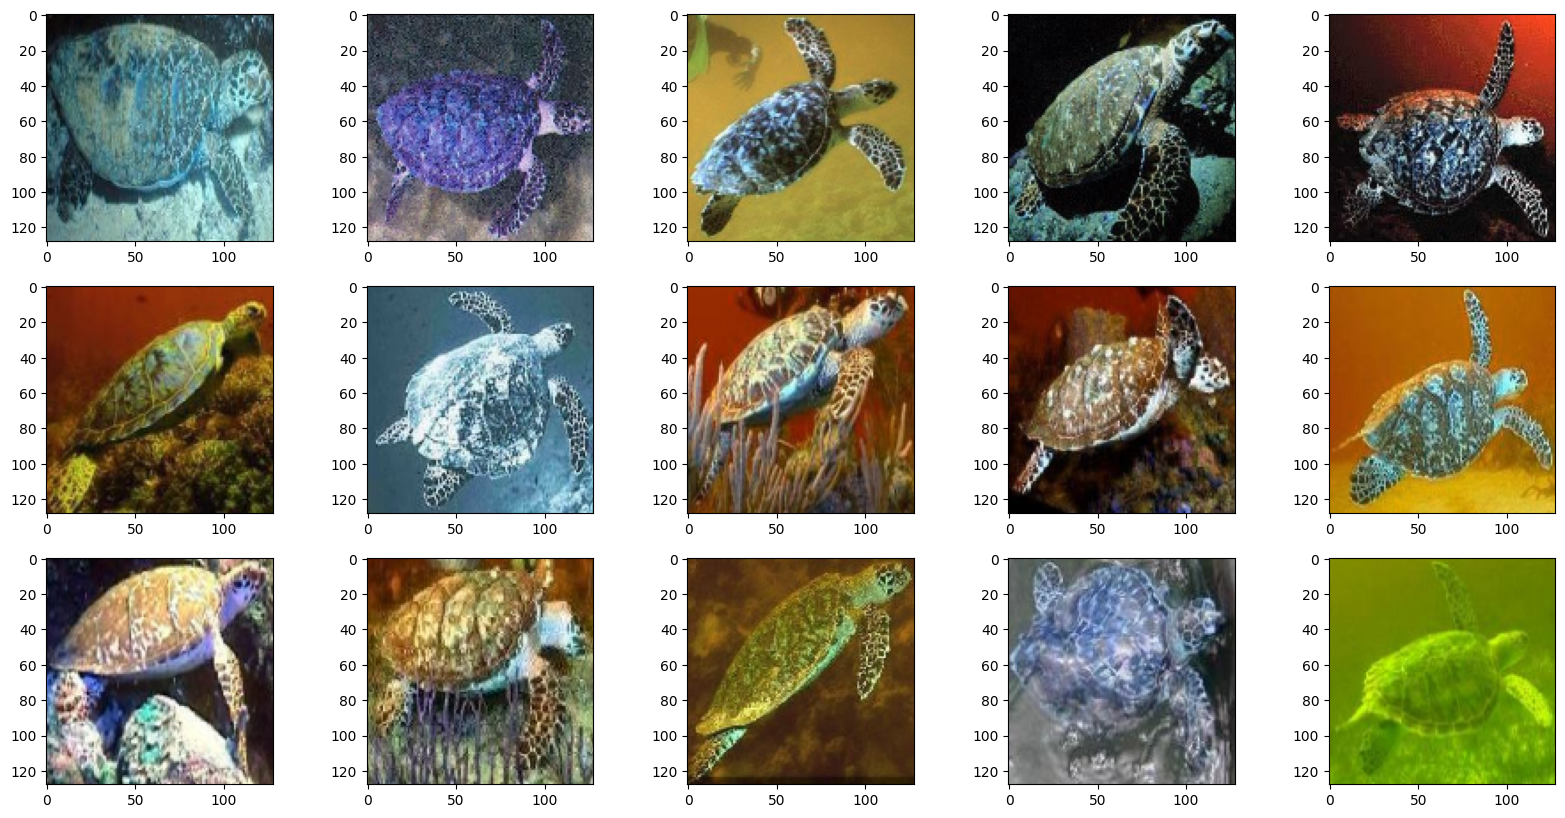

In [6]:
path_to_annotations = './data/my_object/annotations/'
annotations_list = os.listdir(path_to_annotations)
nAnnotations = len(os.listdir(path_to_annotations))
altura = 0
anchura = 0

fig, axs = plt.subplots(3,5, figsize=(20, 10))
i = 0
for annotation in annotations_list:
    if(i >= 15):
        break
    # Número de la anotación/imagen actual
    number = str(annotation)[-8:-4]

    # Obtenemos los valores de las anotaciones
    annot = scipy.io.loadmat(path_to_annotations+str(annotation))
    x, w, y, h = annot["box_coord"][0][0], annot["box_coord"][0][1], annot["box_coord"][0][2], annot["box_coord"][0][3]

    # Sumatorio de altura y anchura
    altura += w - x
    anchura += h - y

    image = cv2.imread('./data/my_object/images/image_{}.jpg'.format(number))
    tmp = image[x:w , y:h]
    tmp = cv2.resize(tmp, (128,128))
    axs[i // 5, i % 5].imshow(tmp)
    i += 1
plt.show()

### Entrenamiento y test

#### Definimos las funciones necesarias para el entrenamiento

Funciones para manejo de datos

In [7]:
# devolve os Paths das imaxes no cartafol indicado
# con extensións como se definen en imgExts
def getImagePaths(folder, imgExts):
  imagePaths = []
  for x in os.listdir(folder):
    xPath = os.path.join(folder, x)
    if os.path.splitext(xPath)[1] in imgExts:
      imagePaths.append(xPath)
  return imagePaths


# Le as imaxes dun cartafol
# devolve a lista de imaxes e etiquetas
def getDataset(folder, classLabel):
  images = []
  labels = []
  imagePaths = getImagePaths(folder, ['.jpg', '.png', '.jpeg'])
  for imagePath in imagePaths:
    # print(imagePath)
    im = cv2.imread(imagePath, cv2.IMREAD_COLOR)
    images.append(im)
    labels.append(classLabel)
  return images, labels

Funciones para configurar el clasificador SVM

In [8]:
# Inicializamos os parametros de SVM
def svmInit(C, gamma):
  model = cv2.ml.SVM_create()
  model.setGamma(gamma)
  model.setC(C)
  model.setKernel(cv2.ml.SVM_LINEAR)
  model.setType(cv2.ml.SVM_C_SVC)
  model.setTermCriteria((cv2.TERM_CRITERIA_EPS + 
                         cv2.TERM_CRITERIA_MAX_ITER, 
                         1000, 1e-3))
  return model


# Adestramos o SVM sobre os datos e as etiquetas
def svmTrain(model, samples, labels):
  model.train(samples, cv2.ml.ROW_SAMPLE, labels)


# predecimos as etiquetas sobre a mostra 
def svmPredict(model, samples):
  return model.predict(samples)[1]


# avaliamos o modelos comparando
# as predicións do modelo coas etiquetas do humano (ground truth)
def svmEvaluate(model, samples, labels):
  labels = labels[:, np.newaxis]
  pred = model.predict(samples)[1]
  correct = np.sum((labels == pred))
  err = (labels != pred).mean()
  print('label -- 1:{}, -1:{}'.format(np.sum(pred == 1), 
          np.sum(pred == -1)))
  return correct, err * 100


# Creamos un directorio se non existe
def createDir(folder):
  try:
    os.makedirs(folder)
  except OSError:
    print('{}: Xa existe'.format(folder))
  except Exception as e:
    print(e)

Funciones para el detector de característica HoG

In [9]:
# achamos as características HOG para as imaxe
def computeHOG(hog, images):
  hogFeatures = []
  for image in images:
    hogFeature = hog.compute(image)
    hogFeatures.append(hogFeature)
  return hogFeatures


# convertemos os desctiptores HOG ao formato recoñecido por SVM
def prepareData(hogFeatures):
  featureVectorLength = len(hogFeatures[0])
  data = np.float32(hogFeatures).reshape(-1, featureVectorLength)
  print(data.shape)
  return data

Función que entrena al modelo

In [10]:
# ================================ Entrenamento do modelo =====================
def trainModel(hog, winSize, name = f'{my_object}_detector'):
    # Lemos as imaxes dos directorio de Pos e Neg 
    trainPosDir = os.path.join('./data/train-test/pos/train')
    trainNegDir = os.path.join('./data/train-test/neg/train')

    # Label 1 para imaxes positivas e -1 as negativas
    trainPosImages, trainPosLabels = getDataset(trainPosDir, 1)
    trainNegImages, trainNegLabels = getDataset(trainNegDir, -1)

    # Redimensionar imagenes al mismo tamaño
    for i in range(len(trainPosImages)):
        trainPosImages[i] = cv2.resize(trainPosImages[i], winSize)

    for i in range(len(trainNegImages)):
        trainNegImages[i] = cv2.resize(trainNegImages[i], winSize)

    # Comprobamos se os tamaños das imaxes son iguais
    print(set([x.shape for x in trainPosImages]))
    print(set([x.shape for x in trainNegImages]))

    # visualizamos o numero de imaxes positivas e negativas que lemos
    print('positivas - {}, {} || negativas - {}, {}'.format(len(trainPosImages),len(trainPosLabels),len(trainNegImages),len(trainNegLabels)))

    # Engadimos Positive/Negative Images/Labels para adestramento
    trainImages = np.concatenate((np.array(trainPosImages), np.array(trainNegImages)), axis=0)
    trainLabels = np.concatenate((np.array(trainPosLabels), np.array(trainNegLabels)), axis=0)
    # Achamos as caracteristicas HOG para adestramento e 
    # convertemos o descriptor HOG ao formato esperado por SVM.
    # Acahamos HOG para as imaxes
    hogTrain = computeHOG(hog, trainImages)

    # Formato para SVM
    trainData = prepareData(hogTrain)

    # Comprobamo as dimensions dos datoa e as etiquetas
    print('trainData: {}, trainLabels:{}'.format(trainData.shape, trainLabels.shape))
    # Creamos o obxecto SVM, entrenamos o modelos e gardamolo.
    model = svmInit(C=0.01, gamma=0)
    svmTrain(model, trainData, trainLabels)
    model.save(str(name)+'.yml')

Función que testea el modelo

In [11]:
# ================================ Test o modelo ===============
def testModel(hog, winSize, name = f'{my_object}_detector'):
    # cargamos o modelo dende disco
    model = cv2.ml.SVM_load('./'+str(name)+'.yml')
    # Avaliaremos o noso conxunto de datos de proba para positivod e
    # imaxes negativas por separado para calcular verdadeiros/falsos positivos
    # e verdadeiros/falsos negativos
    testPosDir = os.path.join('./data/train-test/pos/test/')
    testNegDir = os.path.join('./data/train-test/neg/test/')
    
    # Seguiremos o mesmo fluxo para preparar datos que fixemos para as imaxes de adestramento.
    # Etiqueta 1 para imaxes positivas e -1 para imaxes negativas
    testPosImages, testPosLabels = getDataset(testPosDir, 1)
    testNegImages, testNegLabels = getDataset(testNegDir, -1)

    # Redimensionar imagenes al mismo tamaño
    for i in range(len(testPosImages)):
        testPosImages[i] = cv2.resize(testPosImages[i], winSize)

    for i in range(len(testNegImages)):
        testNegImages[i] = cv2.resize(testNegImages[i], winSize)

    # HoG para as imaxes
    hogPosTest = computeHOG(hog, np.array(testPosImages))
    testPosData = prepareData(hogPosTest)
    
    # Executa a clasificación nos datos da test para as imaxes positivas
    # e calcula os verdadeiros positivos e os falsos positivos.
    posCorrect, posError = svmEvaluate(model, testPosData, np.array(testPosLabels))

    # Calcula falsos positivos e negativos
    tp = posCorrect
    fp = len(testPosLabels) - posCorrect
    print('TP: {}, FP: {}, Total: {}, error: {}'.format(tp, fp, len(testPosLabels), posError))

    # Do mesmo xeito, executa a clasificación dos datos negativos (test)
    # e calcula verdadeiros positivos e os falsos positivos. 
    hogNegTest = computeHOG(hog, np.array(testNegImages))
    testNegData = prepareData(hogNegTest)
    negCorrect, negError = svmEvaluate(model, testNegData, np.array(testNegLabels))

    # falsos negativos e positivos
    tn = negCorrect
    fn = len(testNegData) - negCorrect
    print('TN: {}, FN: {}, Total: {}, error: {}'.format(tn, fn, len(testNegLabels), negError))

    # Achamos Precision e Recall
    precision = tp * 100 / (tp + fp)
    recall = tp * 100 / (tp + fn)
    accuracy = (tp + tn) * 100 / (tp + tn + fp + fn)
    f1_score = 2*precision*recall/(precision+recall)
    print('Precision: {}, Recall: {}, Accuracy: {}, F1-score: {}'.format(precision, recall, accuracy, f1_score))

Parámetros de HoG

In [12]:
# Realizamos distintos entrenamientos/tests modificando los parámetros iniciales
# Prueba 1
print('***** PRUEBA 1 (Valores iniciales) *****')

# Parametros de HOG para inicializar
winSize = (64, 128)
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9
derivAperture = 1
winSigma = -1
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = True
nlevels = 64
signedGradient = False

hog = cv2.HOGDescriptor(winSize, blockSize, blockStride,
                      cellSize, nbins,derivAperture,
                      winSigma, histogramNormType, L2HysThreshold, 
                      gammaCorrection, nlevels,signedGradient)
# Le ponemos un nombre especial para utilizarlo en apartados posteriores (apartado 'g)') descriptor invariante)
print('Training:'); trainModel(hog, winSize, name=f'{my_object}_detectorDefinitivo')
print('\nTest:'); testModel(hog, winSize, name=f'{my_object}_detectorDefinitivo')

# Prueba 2
print('\n***** PRUEBA 2 *****')
winSize = (64, 128)
blockSize = (32, 32)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 32
derivAperture = 2
winSigma = -1
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = True
nlevels = 64
signedGradient = False


hog = cv2.HOGDescriptor(winSize, blockSize, blockStride,
                      cellSize, nbins,derivAperture,
                      winSigma, histogramNormType, L2HysThreshold, 
                      gammaCorrection, nlevels,signedGradient)
print('Training:'); trainModel(hog, winSize)
print('\nTest:'); testModel(hog, winSize)

# Prueba 3
print('\n***** PRUEBA 3 *****')
winSize = (128, 32)
blockSize = (32, 32)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 32
derivAperture = 1
winSigma = -1
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = True
nlevels = 64
signedGradient = False


hog = cv2.HOGDescriptor(winSize, blockSize, blockStride,
                      cellSize, nbins,derivAperture,
                      winSigma, histogramNormType, L2HysThreshold, 
                      gammaCorrection, nlevels,signedGradient)
print('Training:'); trainModel(hog, winSize)
print('\nTest:'); testModel(hog, winSize)

***** PRUEBA 1 (Valores iniciales) *****
Training:
{(128, 64, 3)}
{(128, 64, 3)}
positivas - 80, 80 || negativas - 64, 64
(144, 3780)
trainData: (144, 3780), trainLabels:(144,)

Test:
(20, 3780)
label -- 1:20, -1:0
TP: 20, FP: 0, Total: 20, error: 0.0
(18, 3780)
label -- 1:13, -1:5
TN: 5, FN: 13, Total: 18, error: 72.22222222222221
Precision: 100.0, Recall: 60.60606060606061, Accuracy: 65.78947368421052, F1-score: 75.47169811320754

***** PRUEBA 2 *****
Training:
{(128, 64, 3)}
{(128, 64, 3)}
positivas - 80, 80 || negativas - 64, 64
(144, 33280)
trainData: (144, 33280), trainLabels:(144,)

Test:
(20, 33280)
label -- 1:20, -1:0
TP: 20, FP: 0, Total: 20, error: 0.0
(18, 33280)
label -- 1:8, -1:10
TN: 10, FN: 8, Total: 18, error: 44.44444444444444
Precision: 100.0, Recall: 71.42857142857143, Accuracy: 78.94736842105263, F1-score: 83.33333333333333

***** PRUEBA 3 *****
Training:
{(32, 128, 3)}
{(32, 128, 3)}
positivas - 80, 80 || negativas - 64, 64
(144, 6656)
trainData: (144, 6656), trai

#### Análisis de los resultados
- Prueba 1: En esta prueba se utilizan los valores por defecto definidos en '3_Object_Detection_con_HOG_SVM.ipynb', vemos que los resultados son bastante buenos, es decir, es capaz de detectar en gran parte el objeto en las imágenes en las que aparece y de no detectarlo en las que no.
- Prueba 2: En esta prueba se modifican los valores de los parámetros 'blockSize', 'nbins' y 'derivAperture' aumentando su valor, lo cual mejora los resultados de nuestro detector a cambio de un mayor costo computacional.
- Prueba 3: Por último, se mantienen los valores de 'blockSize' y 'nbins' pero se modifica del tamaño de la ventana a uno que no es óptimo y el resultado es el esperado. En la primera y segunda prueba trabajabamos con un tamaño de ventana bastante bueno (calculado anteriormente) y al modificarlo a uno distinto vemos como los resultados empeoran.

Observando los resultados nos quedamos con la prueba 2 ya que presenta los mejores valores para las métricas utilizadas.

### Implementamos otro clasificador: **random forest**

Función que entrena al modelo

In [13]:
# ================================ Entrenamento do modelo =====================
def trainModelRandomForest(hog, winSize, name = f'{my_object}_detectorTree'):
    # Lemos as imaxes dos directorio de Pos e Neg 
    trainPosDir = os.path.join("./data/train-test/pos/train/")
    trainNegDir = os.path.join("./data/train-test/neg/train/")

    # Label 1 para imaxes positivas e -1 as negativas
    trainPosImages, trainPosLabels = getDataset(trainPosDir, 1)
    trainNegImages, trainNegLabels = getDataset(trainNegDir, -1)
    
    # Redimensionar imagenes al mismo tamaño
    for i in range(len(trainPosImages)):
        trainPosImages[i] = cv2.resize(trainPosImages[i], winSize)

    for i in range(len(trainNegImages)):
        trainNegImages[i] = cv2.resize(trainNegImages[i], winSize)

    # Comprobamos se os tamaños das imaxes son iguais
    print(set([x.shape for x in trainPosImages]))
    print(set([x.shape for x in trainNegImages]))


    # visualizamos o numero de imaxes positivas e negativas que lemos
    print('positivas - {}, {} || negativas - {}, {}'.format(len(trainPosImages),len(trainPosLabels),len(trainNegImages),len(trainNegLabels)))

    # Engadimos Positive/Negative Images/Labels para adestramento
    trainImages = np.concatenate((np.array(trainPosImages), np.array(trainNegImages)), axis=0)
    trainLabels = np.concatenate((np.array(trainPosLabels), np.array(trainNegLabels)),axis=0)
    # Achamos as caracteristicas HOG para adestramento e 
    # convertemos o descriptor HOG ao formato esperado por SVM.
    # Acahamos HOG para as imaxes
    hogTrain = computeHOG(hog, trainImages)

    # Formato para SVM
    trainData = prepareData(hogTrain)

    # Comprobamo as dimensions dos datoa e as etiquetas
    # Creamos o obxecto SVM, entrenamos o modelos e gardamolo.
    model = RandomForestClassifier(n_estimators=100)
    model.fit(trainData, trainLabels)

    file = open('./'+str(name)+'.yml', 'wb')
    pickle.dump(model, file)

Función que testea el modelo

In [14]:
# ================================ Test o modelo ===============
def testModelRandomForest(hog, winSize, name = f'{my_object}_detectorTree'):
    # cargamos o modelo dende disco
    model = pickle.load(open('./'+str(name)+'.yml', 'rb'))
    # Avaliaremos o noso conxunto de datos de proba para positivod e
    # imaxes negativas por separado para calcular verdadeiros/falsos positivos
    # e verdadeiros/falsos negativos
    testPosDir = os.path.join('./data/train-test/pos/test/')
    testNegDir = os.path.join('./data/train-test/neg/test/')
    
    # Seguiremos o mesmo fluxo para preparar datos que fixemos para as imaxes de adestramento.
    # Etiqueta 1 para imaxes positivas e -1 para imaxes negativas
    testPosImages, testPosLabels = getDataset(testPosDir, 1)
    testNegImages, testNegLabels = getDataset(testNegDir, -1)

    # Redimensionar imagenes al mismo tamaño
    for i in range(len(testPosImages)):
        testPosImages[i] = cv2.resize(testPosImages[i], winSize)

    for i in range(len(testNegImages)):
        testNegImages[i] = cv2.resize(testNegImages[i], winSize)

    # HoG para as imaxes
    hogPosTest = computeHOG(hog, np.array(testPosImages))
    testPosData = prepareData(hogPosTest)
    
    # Executa a clasificación nos datos da test para as imaxes positivas
    # e calcula os verdadeiros positivos e os falsos positivos.
    posCorrect, posError = svmEvaluate(model, testPosData, np.array(testPosLabels))

    # Calcula falsos positivos e negativos
    tp = posCorrect
    fp = len(testPosLabels) - posCorrect
    print('TP: {}, FP: {}, Total: {}, error: {}'.format(tp, fp, len(testPosLabels), posError))

    # Do mesmo xeito, executa a clasificación dos datos negativos (test)
    # e calcula verdadeiros positivos e os falsos positivos. 
    hogNegTest = computeHOG(hog, np.array(testNegImages))
    testNegData = prepareData(hogNegTest)
    negCorrect, negError = svmEvaluate(model, testNegData, np.array(testNegLabels))

    # falsos negativos e positivos
    tn = negCorrect
    fn = len(testNegData) - negCorrect
    print('TN: {}, FN: {}, Total: {}, error: {}'.format(tn, fn, len(testNegLabels), negError))

    # Achamos Precision e Recall
    precision = tp * 100 / (tp + fp + 0.0000000000001)
    recall = tp * 100 / (tp + fn + 0.0000000000001)
    accuracy = (tp + tn) * 100 / (tp + tn + fp + fn + 0.0000000000001)
    f1_score = 2*precision*recall/(precision+recall + 0.0000000000001)
    print('Precision: {}, Recall: {}, Accuracy: {}, F1-score: {}'.format(precision, recall, accuracy, f1_score))

Parámetros de HoG

In [15]:
# Realizamos distintos entrenamientos/tests modificando los parámetros iniciales
# Prueba 1
print('***** PRUEBA 1  (Valores iniciales) *****')

# Parametros de HOG para inicializar
winSize = (64, 128)
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9
derivAperture = 1
winSigma = -1
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = True
nlevels = 64
signedGradient = False

hog = cv2.HOGDescriptor(winSize, blockSize, blockStride,
                      cellSize, nbins,derivAperture,
                      winSigma, histogramNormType, L2HysThreshold, 
                      gammaCorrection, nlevels,signedGradient)
print('Training:'); trainModelRandomForest(hog, winSize)
print('\nTest:'); testModelRandomForest(hog, winSize)

***** PRUEBA 1  (Valores iniciales) *****
Training:
{(128, 64, 3)}
{(128, 64, 3)}
positivas - 80, 80 || negativas - 64, 64
(144, 3780)

Test:
(20, 3780)
label -- 1:1, -1:0
TP: 20, FP: 0, Total: 20, error: 0.0
(18, 3780)
label -- 1:0, -1:1
TN: 18, FN: 0, Total: 18, error: 0.0
Precision: 99.9999999999995, Recall: 99.9999999999995, Accuracy: 99.99999999999974, F1-score: 99.99999999999945


#### Análisis de los resultados
Utilizando el clasificador Random Forest con los parámetros iniciales obtenemos casi un 100% de acierto en todas las métricas por lo que es una mejora bastante notable comparándolo con el clasificador anterior.

### Finalmente, cambiaremos el detector HoG por otro invariante

Funciones necesarias para el nuevo detector

In [16]:
def pyramid(image, scale=1.5, minSize=(30, 30)):
    """
    Genera una pirámide de imágenes.

    Argumentos:
    - image: La imagen de entrada para la generación de la pirámide.
    - scale: Factor de escala para redimensionar la imagen en cada iteración.
    - minSize: Tamaño mínimo de la imagen para detener la generación de la pirámide.

    Devuelve:
    - Image: Imágenes redimensionadas que forman la pirámide de imágenes.
    """
    yield image  # Rinde la imagen original
    while True:
        w = int(image.shape[1] / scale)  # Calcula el nuevo ancho basado en la escala
        image = imutils.resize(image, width=w)  # Redimensiona la imagen
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break  # Rompe si el tamaño de la imagen es inferior al tamaño mínimo
        yield image  # Rinde la imagen redimensionada


def sliding_window(image, stepSize, windowSize):
    """
    Genera posiciones de ventana deslizante sobre una imagen.

    Argumentos:
    - image: La imagen de entrada sobre la cual deslizar la ventana.
    - stepSize: El tamaño del paso para deslizar la ventana.
    - windowSize: Tamaño de la ventana deslizante.

    Devuelve:
    - Tuple: (x, y, ventana) - Posición y contenido de la ventana deslizante.
    """
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
            # Rinde la posición y el contenido de la ventana deslizante


def non_max_suppression_slow(boxes, overlapThresh):
    """
    Realiza supresión de no máximo en cajas delimitadoras.

    Argumentos:
    - boxes: Matriz de cajas delimitadoras en formato (x1, y1, x2, y2).
    - overlapThresh: Valor de umbral para la superposición de cajas delimitadoras.

    Devuelve:
    - Array: Cajas delimitadoras seleccionadas después de la supresión.
    """
    if len(boxes) == 0:
        return []

    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]

        for pos in range(0, last):
            j = idxs[pos]
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)

            overlap = float(w * h) / area[j]
            if overlap > overlapThresh:
                suppress.append(pos)

        idxs = np.delete(idxs, suppress)

    return boxes[pick]

Parches positivos:


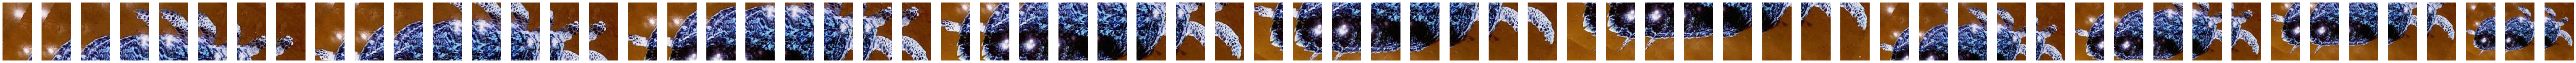

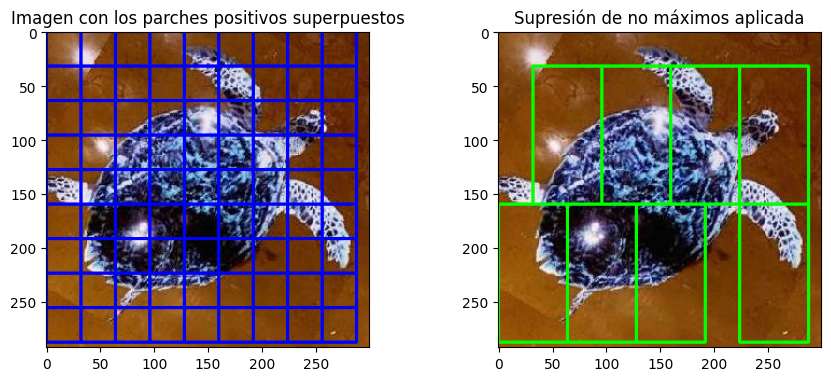

In [17]:
ruta_imagen_prueba = './data/train-test/pos/test/image_0014.jpg'
image = cv2.imread(ruta_imagen_prueba)
model = cv2.ml.SVM_load('./'+str(my_object)+'_detectorDefinitivo.yml')  # Carga el modelo óptimo guardado con nombre especial anteriormente

(winW, winH) = (64, 128)  # Tamaño de la ventana deslizante
detections = []  # Almacenará las detecciones positivas
windows = []  # Almacenará las ventanas donde se encuentran las detecciones

# Bucle para aplicar la ventana deslizante y extraer características HOG
for resized in pyramid(image, scale=1.5):  # Escalado piramidal de la imagen
    for (x, y, window) in sliding_window(resized, stepSize=32, windowSize=(winW, winH)):
        if window.shape[0] != winH or window.shape[1] != winW:  # Descarta ventanas que no cumplen el tamaño deseado
            continue
        hogFeatures = hog.compute(window)  # Calcula las características HOG para la ventana actual
        windowData = np.float32(hogFeatures).reshape(-1, len(hogFeatures))
        prediccion = model.predict(windowData)[1][0][0]  # Realiza la predicción con el modelo SVM
        if prediccion == 1:  # Si la predicción es positiva
            windows.append(window)  # Agrega la ventana a la lista de ventanas positivas
            detections.append(((x, y, x + winW, y + winH)))  # Registra la detección con sus coordenadas

num_imagenes = len(windows)  # Número de detecciones positivas
ancho_figura = num_imagenes * 2  # Ancho de la figura para visualizar las detecciones
alto_figura = 3  # Alto de la figura para visualizar las detecciones

# Muestra las imágenes con las detecciones positivas
fig, axs = plt.subplots(1, num_imagenes, figsize=(ancho_figura, alto_figura))
for i, imagen in enumerate(windows):
    axs[i].imshow(imagen)
    axs[i].axis('off')
print('Parches positivos:')
plt.show()

# Si se encontraron detecciones positivas
if len(detections) > 0:
    detections = np.array(detections)
    images = [(ruta_imagen_prueba, detections)]  # Lista de imágenes con sus cajas delimitadoras
    for (imagePath, boundingBoxes) in images:
        image = cv2.imread(imagePath)
        copy = image.copy()  # Copia de la imagen original
        orig = image.copy()  # Otra copia de la imagen original

        # Dibuja rectángulos alrededor de las detecciones originales
        for (startX, startY, endX, endY) in boundingBoxes:
            cv2.rectangle(copy, (startX, startY), (endX, endY), (0, 0, 255), 2)

        # Aplica la supresión de no máximos a las detecciones
        pick = non_max_suppression_slow(boundingBoxes, 0.11)

        # Dibuja rectángulos alrededor de las detecciones tras la supresión de no máximos
        for (startX, startY, endX, endY) in pick:
            cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
        
        # Muestra las imágenes con las detecciones y la supresión de no máximos
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(copy)
        axs[0].set_title("Imagen con los parches positivos superpuestos")
        axs[1].imshow(image)
        axs[1].set_title("Supresión de no máximos aplicada")
        plt.subplots_adjust(wspace=0.4)
        plt.show()

### Análisis del resultado obtenido
Podemos ver que mediante el uso de ventanas deslizantes y la supresión de no máximos como se muestra en la imagen superior podemos conseguir un detector multiescala, con el cual al variar una imagen a distintas escalas nos proporciona todos los parches positivos en distintas escalas (imagen de la izquierda) y al aplicar supresión de no máximos solo nos quedamos con las ventanas con mayor información a la hora de detectar el objeto (imagen de la derecha).